In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import pickle
import json
import torch

from PIL import Image
from matplotlib import patches
from pathlib import Path
from tqdm.autonotebook import tqdm
from typing import Dict, List, Tuple

from extract_features import get_all_annotations

In [4]:
dataset_file = '/data/patho/Astma/cells_df.csv'
img_dir = '/data/patho/Astma/'
figure_dir = Path('figures/')
result_dir = Path('results/')
feature_dir = Path('/data/jonas/astma/features')
metric_dir = Path('results/')

In [5]:
import utils.constants as constants
from utils.dataset_adaptors import load_astma_df

# load data 
_, test_dataset, lookups = load_astma_df(dataset_file)

# filter test samples 

# create test codes
test_codes = {0: 'None'}

# get test samples and labels
test_samples = get_all_annotations(
    dataset=test_dataset, 
    img_dir_path=img_dir, 
    domain_col='None',
    box_format='xyxy'
    )

# testset labels
test_annos = torch.tensor([v for l in test_samples.values() for v in l['labels']])
if 'midog' in dataset_file.lower():
    test_annos -= 1

In [6]:
model_name = 'yolov7_astma_0'

print('Loading features and targets ...', end=' ')
if not feature_dir.joinpath('features_' + model_name + '.pkl').exists():
    raise FileNotFoundError(f'Features for model {model_name} not found.')
else:
    features = pickle.load(open(feature_dir.joinpath('features_' + model_name + '.pkl'), 'rb'))

if not feature_dir.joinpath('domains_' + model_name + '.pkl').exists():
    raise FileNotFoundError(f'Domains for model {model_name} not found.')
else:
    domains = pickle.load(open(feature_dir.joinpath('domains_' + model_name + '.pkl'), 'rb'))
print('Done.')


Loading features and targets ... Done.


In [7]:
for name, values in features.items():
    print(name, values.shape)

model.11 torch.Size([29003, 256])
model.24 torch.Size([29003, 512])
model.37 torch.Size([29003, 1024])
model.50 torch.Size([29003, 1024])
model.63 torch.Size([29003, 256])
model.75 torch.Size([29003, 128])
model.88 torch.Size([29003, 256])
model.101 torch.Size([29003, 512])
model.102 torch.Size([29003, 256])
model.103 torch.Size([29003, 512])
model.104 torch.Size([29003, 1024])
model.105.m.0 torch.Size([29003, 60])
model.105.m.1 torch.Size([29003, 60])
model.105.m.2 torch.Size([29003, 60])


In [8]:
def load_metrics(filename, metric):
    all_metric_data = json.load(open(filename, 'rb'))
    aggregates = all_metric_data['aggregates']
    metric_dict = {}
    for key in aggregates:
        if key.endswith(metric):
            metric_dict[key] = aggregates[key]
    return metric_dict, all_metric_data

In [9]:
import utils.constants as constants
import plotly.express as px
import plotly.graph_objects as go 
import itertools

from plotly.subplots import make_subplots


def get_similarity(
        model_name: str, 
        result_dir: str, 
        metric_dir: str, 
        detector: str='FCOS', 
        metric: str='AP', 
        all_models: bool=False,
        num_models: int = 5,
        plot: bool=False
        ) -> None:
    
        # get dataset codes
        abbrevs = constants.MIDOG_ABBREVATIONS

        # get layer codes
        if detector == 'FCOS':
            layer_codes = constants.FCOS_LAYER_CODES
        elif detector == 'yolov7_d6':
            layer_codes = constants.YOLO_D6_LAYER_CODES
        elif detector == 'yolov7':
             layer_codes = constants.YOLO_LAYER_CODES
        else:
             raise NotImplementedError()


        if all_models:
                dfs = []
                for i in range(num_models):
                        
                    try:
                        model_name = model_name[:-1] + str(i)
                        # load hdv results
                        hdv_filename = os.path.join(result_dir, 'hdv_' + model_name + '.pkl')
                        hdv_scores = pickle.load(open(hdv_filename, 'rb'))

                        # load metric results
                        metrics_filename = os.path.join(metric_dir, model_name + '.json')
                        metric_data, _ = load_metrics(metrics_filename, metric=metric, test_codes=test_codes)

                        # create long dataframe
                        df = pd.DataFrame(hdv_scores)
                        df['Tumortype'] = df.index.map(test_codes)
                        df['Tumortype'] = df.index.map(abbrevs)
                        df[metric] = df.index.map(metric_data)
                        df = df.melt(id_vars=['Tumortype', metric], var_name='Layer' )
                        df['run'] = i
                        dfs.append(df)
                        df = pd.concat(dfs)
                    except:
                        continue

        else:

                # load hdv results
                hdv_filename = os.path.join(result_dir, 'hdv_' + model_name + '.pkl')
                hdv_scores = pickle.load(open(hdv_filename, 'rb'))

                # load metric results
                metrics_filename = os.path.join(metric_dir, model_name + '.json')
                metric_data, _ = load_metrics(metrics_filename, metric=metric, test_codes=test_codes)

                # create long dataframe
                df = pd.DataFrame(hdv_scores)
                df['Tumortype'] = df.index.map(test_codes)
                df['Tumortype'] = df.index.map(abbrevs)
                df[metric] = df.index.map(metric_data)
                df = df.melt(id_vars=['Tumortype', metric], var_name='Layer' )

        # rename layers
        df['Layer'] = df['Layer'].map(layer_codes)

        # drop layers
        df.drop(df[df['Tumortype'] == 'HAC'].index, inplace=True)
        df.drop(df[df['Layer'] == 'P1'].index, inplace=True)

        if plot:
            fig = px.scatter(
            df, x=metric, y='value', 
            color='Tumortype', facet_col='Layer', facet_col_wrap=5, labels={'value': 'HDV'})
            fig.show()

        else:
            return df 


In [ ]:
def plot_class_separation_heatmap(data, class_names=None):
    # Find the maximum class number to create a square matrix
    all_classes = set()
    for pair in data:
        if pair == 'avg':
            continue
        all_classes.update(pair)

    class_count = max(all_classes) + 1

    # Create an empty matrix (NaN initialized)
    heatmap_data = np.full((class_count, class_count), np.nan)

    # Populate the matrix with the dictionary values
    for pair, separation in data.items():
        if pair == 'avg':
            continue
        class1, class2 = pair 
        heatmap_data[class1, class2] = separation
        heatmap_data[class2, class1] = separation  # Symmetric matrix

    # Convert the matrix to a DataFrame for better visualization with seaborn
    df = pd.DataFrame(heatmap_data)

    # set class names as labels if provided
    if class_names:
        class_labels = [class_names[i] for i in all_classes]
        df.index = class_labels
        df.columns = class_labels

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(df, annot=True, cmap="coolwarm", mask=np.isnan(df), cbar=True, vmin=0, vmax=1)
    plt.title("Class Separation Heatmap")
    plt.xlabel("Class")
    plt.ylabel("Class")
    plt.show()

In [12]:
# plot_class_separation_heatmap(hdv_scores['model.11'][0], class_names=lookups['class_id_to_label'])

In [13]:
# for layer in hdv_scores:
#     print(layer)

#     plot_class_separation_heatmap(hdv_scores[layer][0], class_names=lookups['class_id_to_label'])

In [20]:
from scipy.stats import sem

def plot_multiclass_similarity(
        model_name: str, 
        layer_name: str, 
        result_dir: str, 
        class_names: Dict[int, str] = None,
        detector: str='FCOS', 
        all_models: bool=False,
        num_models: int = 5,
        plot: bool=False
        ) -> None:
            
            
        # get dataset codes
        if 'astma' in model_name:
             abbrevs = {0: 'None'}
        else:
            abbrevs = constants.MIDOG_ABBREVATIONS

        # get layer codes
        if detector == 'FCOS':
            layer_codes = constants.FCOS_LAYER_CODES
        elif detector == 'yolov7_d6':
            layer_codes = constants.YOLO_D6_LAYER_CODES
        elif detector == 'yolov7':
             layer_codes = constants.YOLO_LAYER_CODES
        else:
             raise NotImplementedError()
    

        scores_list = []
        for i in range(num_models):
                
            try:
                model_name = model_name[:-1] + str(i)
                # load hdv results
                hdv_filename = os.path.join(result_dir, 'hdv_' + model_name + '.pkl')
                hdv_scores = pickle.load(open(hdv_filename, 'rb'))

                if layer_name not in hdv_scores:
                        raise ValueError(f'Layer {layer_name} not found.')
            
                for domain, domain_values in hdv_scores[layer_name].items():
                    scores_list.append(domain_values) 

            except:
                    continue
            
        aggregated_data = {}
        for data in scores_list:
                for key, value in data.items():
                    if key == 'avg':
                         continue
                    if key not in aggregated_data:
                        aggregated_data[key] = []
                    aggregated_data[key].append(value)

        all_classes = set()
        for pair in aggregated_data:
            if pair == 'avg':
                 continue
            all_classes.update(pair)


        class_count = max(all_classes) + 1


        # create empty matrices (NaN initialized) for mean and CI
        mean_matrix = np.full((class_count, class_count), np.nan)
        ci_matrix = np.full((class_count, class_count), np.nan)

        # calculate mean and confidence intervals for each class pair
        for (class1, class2), values in aggregated_data.items():
            mean_value = np.mean(values)
            ci_value = sem(values) * 1.96  # 95% CI (assuming normal distribution)
            # mean_matrix[class1, class2] = mean_value
            mean_matrix[class2, class1] = mean_value  # Symmetric matrix
            # ci_matrix[class1, class2] = ci_value
            ci_matrix[class2, class1] = ci_value  # Symmetric matrix

        # create a DataFrame for the heatmap and set class labels
        df_mean = pd.DataFrame(mean_matrix)
        # set class names as labels if provided
        if class_names:
            class_labels = [class_names[i] for i in all_classes]
            df_mean.index = class_labels
            df_mean.columns = class_labels

        # prepare annotations with mean and CI
        annotations = np.empty_like(df_mean, dtype=object)
        for i in range(class_count):
            for j in range(class_count):
                if not np.isnan(df_mean.iloc[i, j]):
                    annotations[i, j] = f"{df_mean.iloc[i, j]:.2f} ± {ci_matrix[i, j]:.2f}"
                else:
                    annotations[i, j] = ""


        layer_code = layer_codes[layer_name]

        plt.figure(figsize=(10, 8))
        sns.heatmap(df_mean, annot=annotations, fmt="", cmap="coolwarm", mask=np.isnan(df_mean), cbar=True, vmin=0, vmax=1)
        plt.title(f"HDV at layer {layer_code} with Mean ± CI")
        plt.xlabel("Class")
        plt.ylabel("Class")
        plt.show()                  

In [15]:
def plot_average_similarity(
        model_name: str, 
        result_dir: str, 
        metric_dir: str, 
        metric: str,
        detector: str='FCOS', 
        num_models: int = 5,
        plot: bool=False
        ) -> None:
            

        # get layer codes
        if detector == 'FCOS':
            layer_codes = constants.FCOS_LAYER_CODES
        elif detector == 'yolov7_d6':
            layer_codes = constants.YOLO_D6_LAYER_CODES
        elif detector == 'yolov7':
             layer_codes = constants.YOLO_LAYER_CODES
        else:
             raise NotImplementedError()
        

        scores_list = []
        for i in range(num_models):
                
            try:
                model_name = model_name[:-1] + str(i)

                # load hdv results
                hdv_filename = os.path.join(result_dir, 'hdv_' + model_name + '.pkl')
                hdv_scores = pickle.load(open(hdv_filename, 'rb'))
                scores = {layer: scores[0]['avg'] for layer, scores in hdv_scores.items()}

                # load metric results
                metrics_filename = os.path.join(metric_dir, model_name + '.json')
                metric_data, _ = load_metrics(metrics_filename, metric=metric)

                scores.update(metric_data)
                scores.update({'model': i})
                scores_list.append(scores)

            except:
                    continue
            
        df = pd.DataFrame(scores_list)
        df = df.melt(id_vars=['model', 'mAP'], var_name='Layer')
        
        # rename layers
        df['Layer'] = df['Layer'].map(layer_codes)

        if plot:
            fig = px.scatter(
                df, x=metric, y='value', facet_col='Layer', facet_col_wrap=5
            )
            fig.show()

        else:
             return df 
    

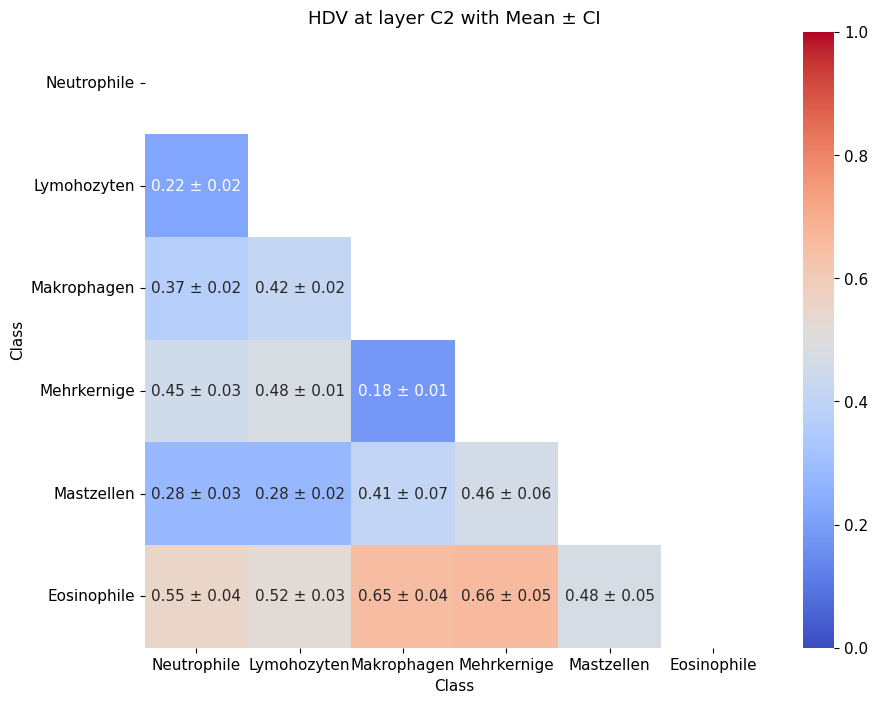

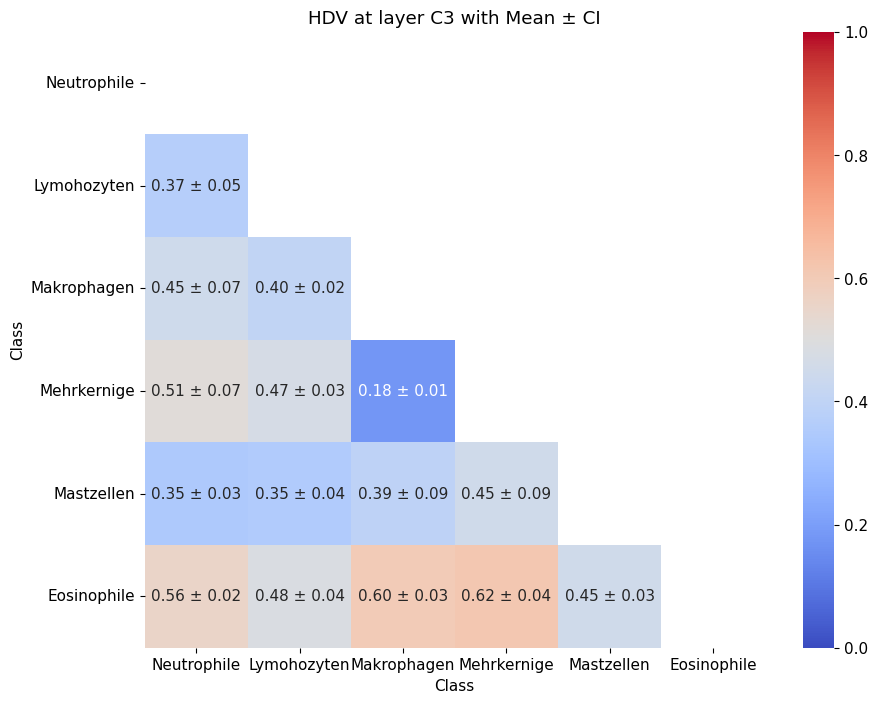

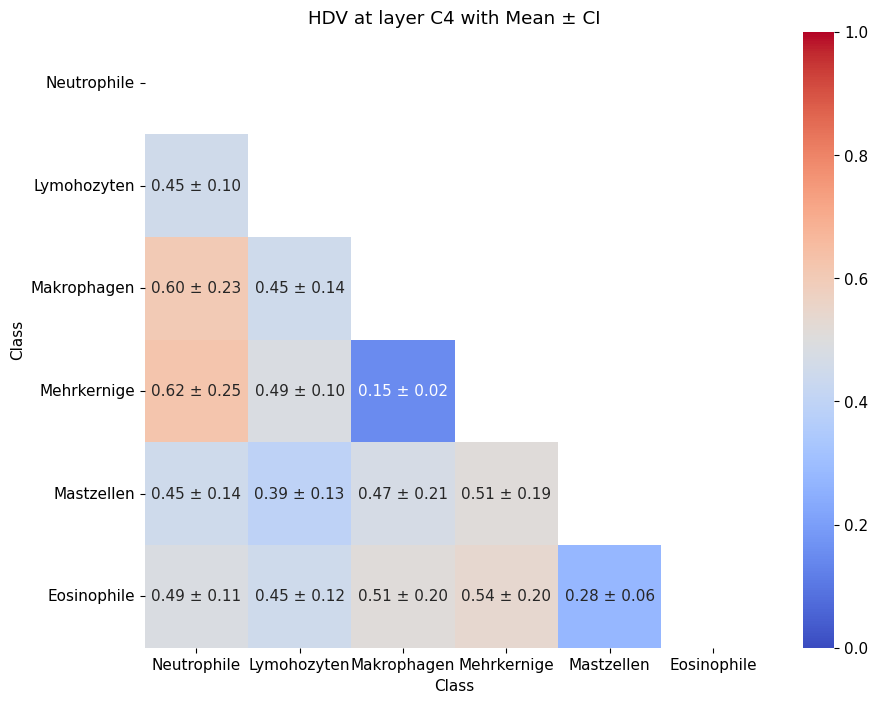

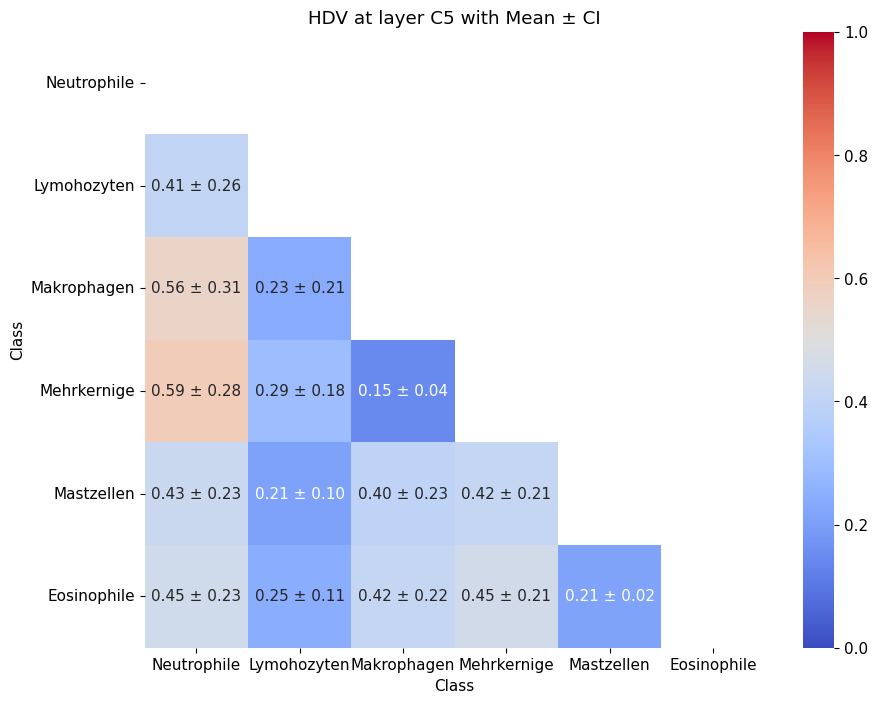

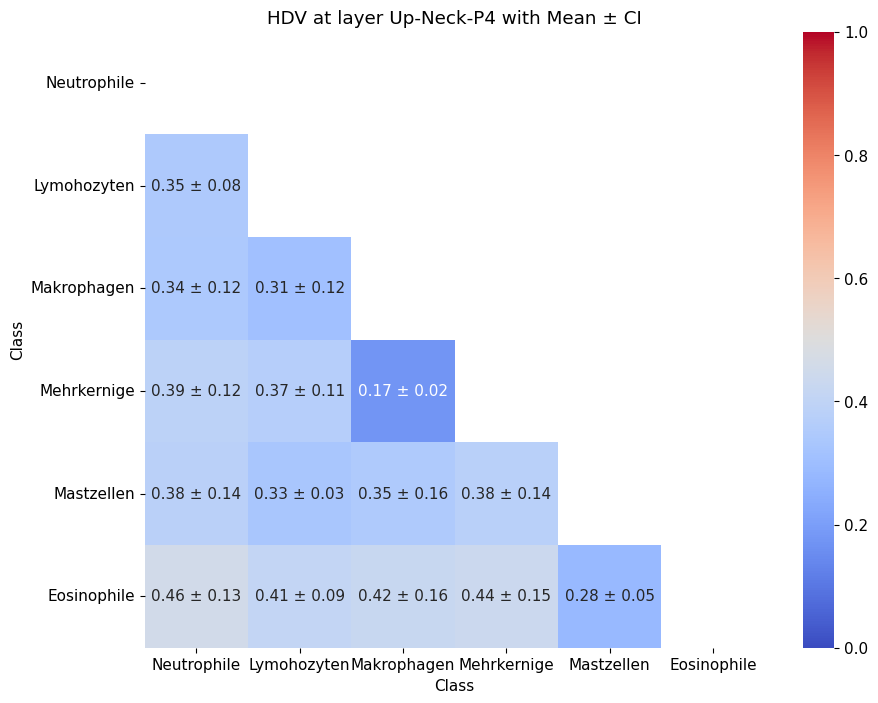

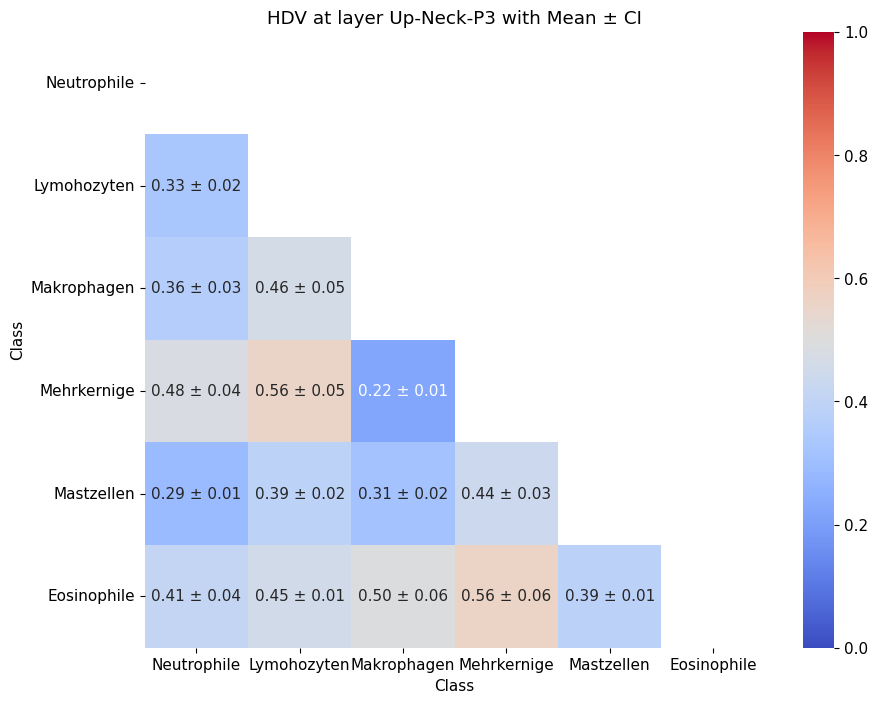

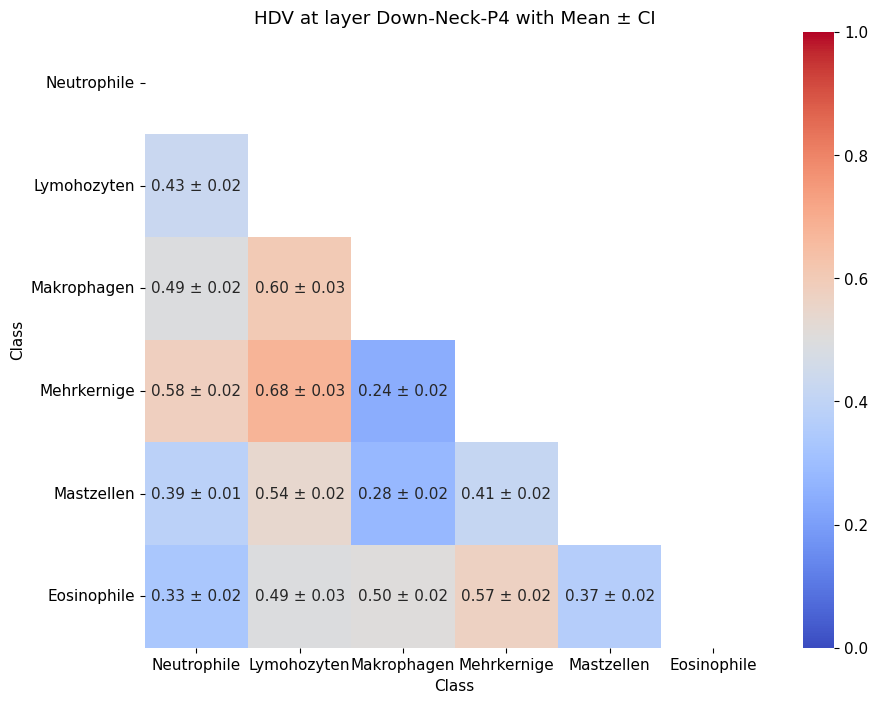

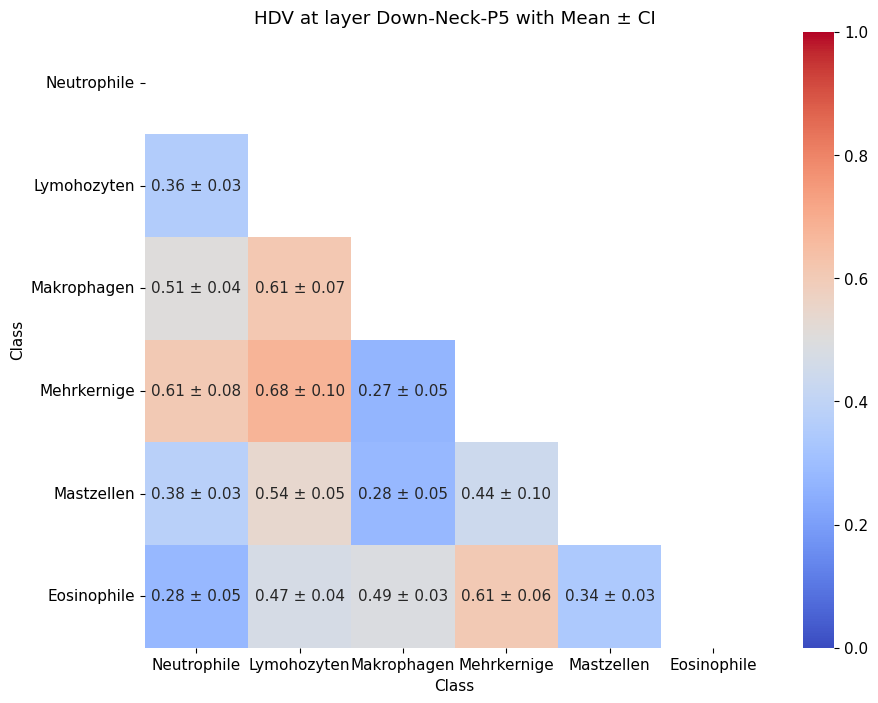

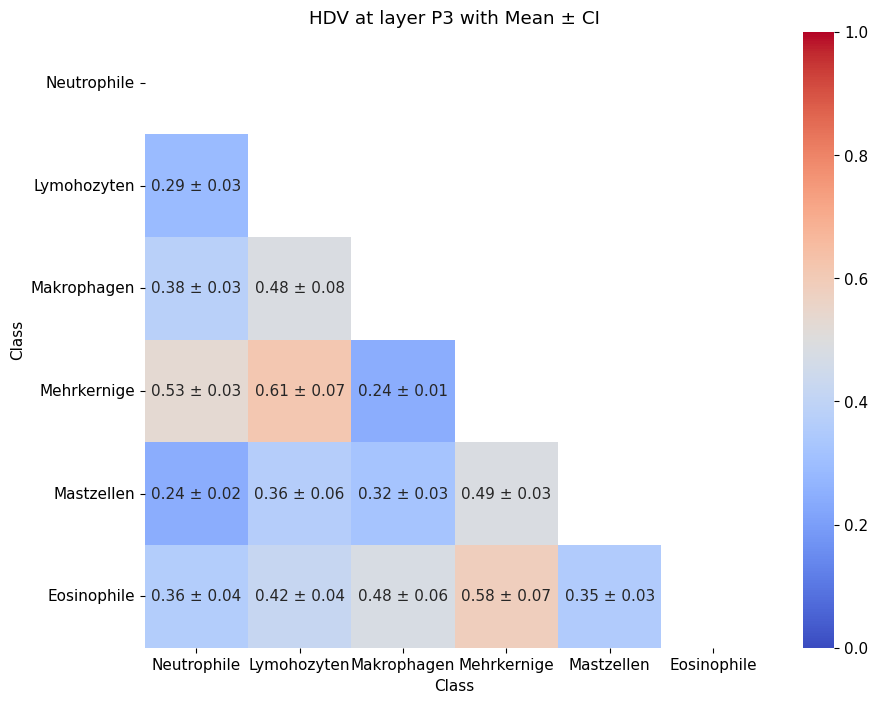

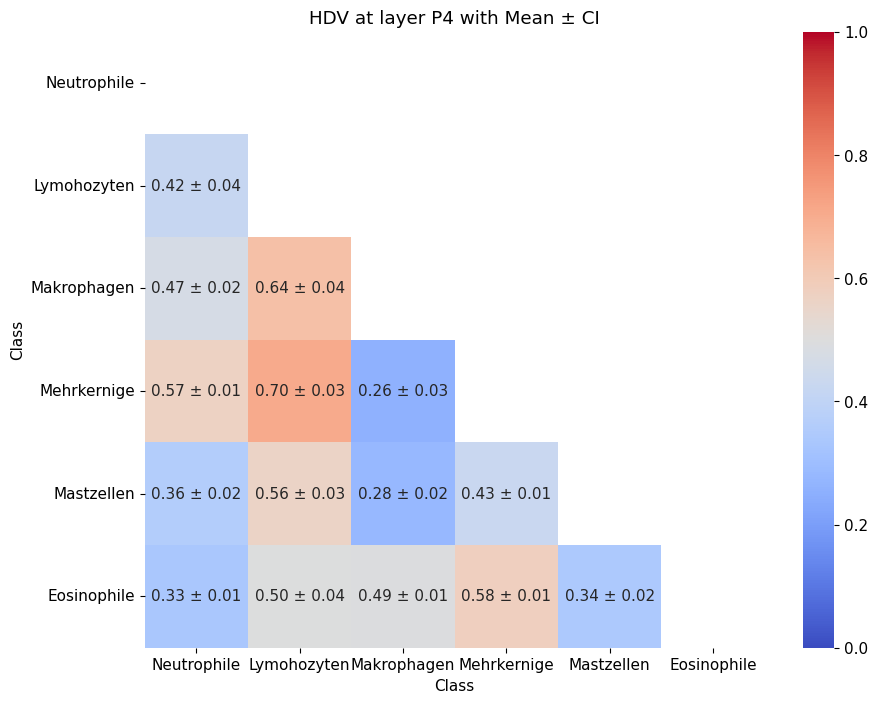

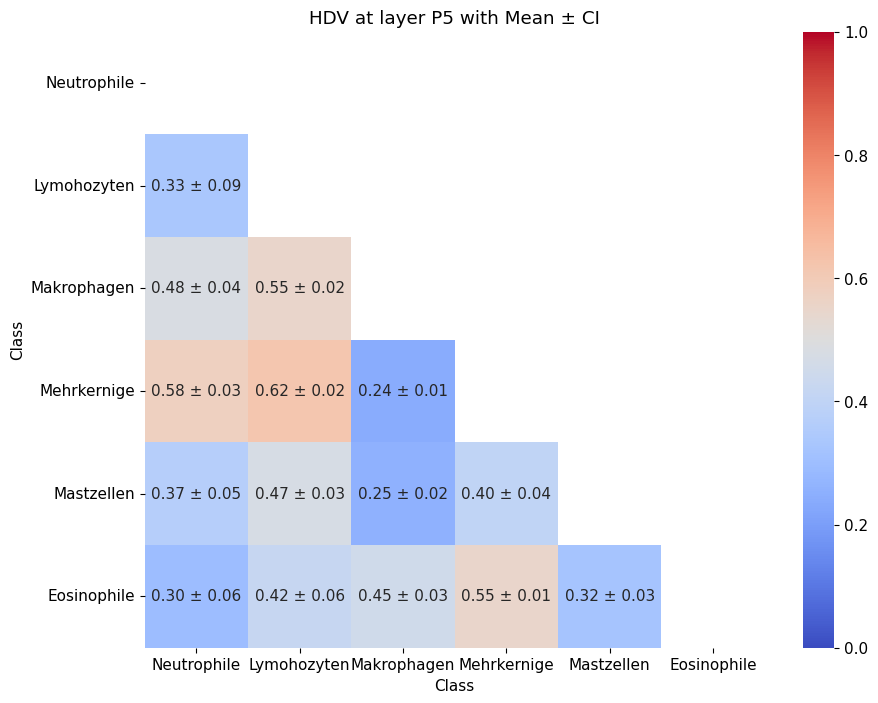

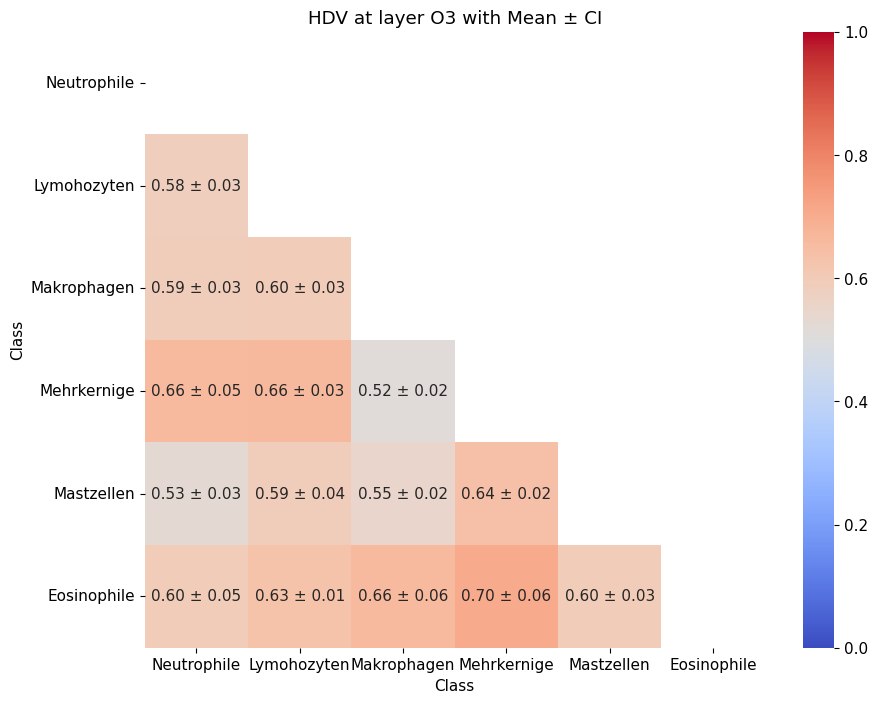

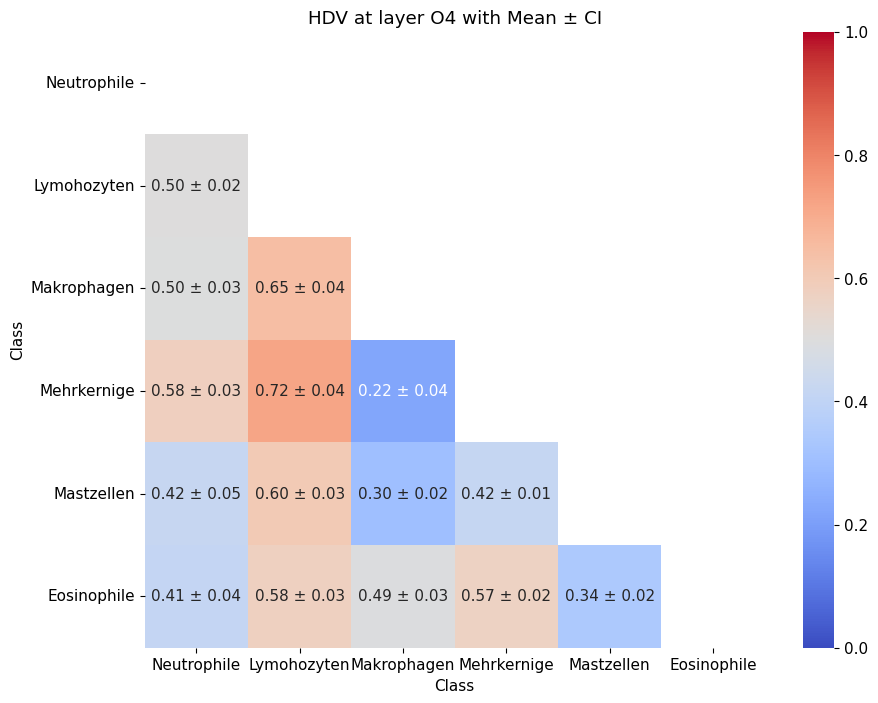

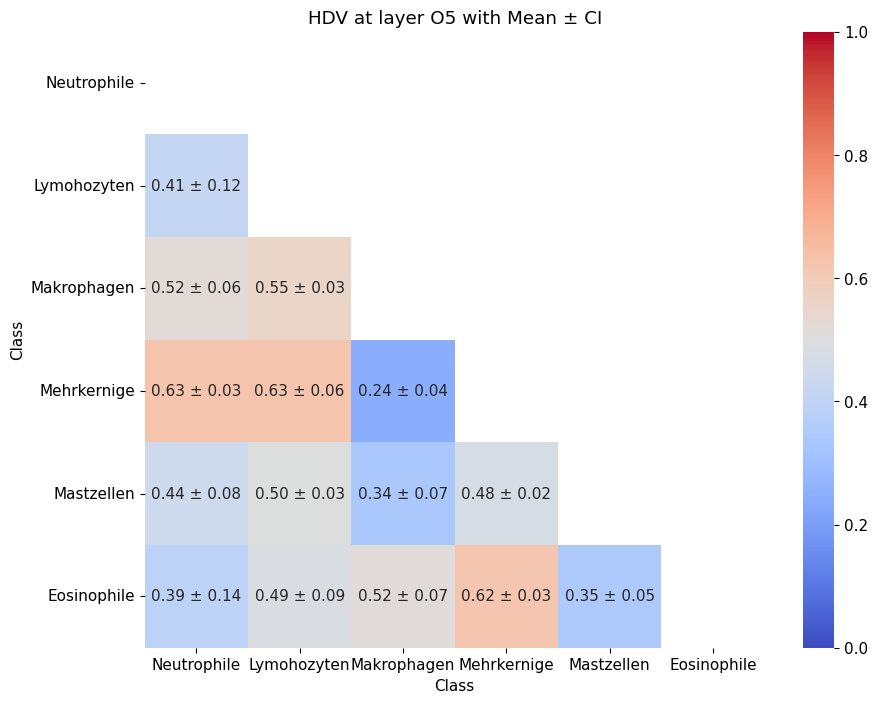

In [22]:
%matplotlib inline

model_name = 'yolov7_astma_0'
result_dir = 'results/astma'
class_names = lookups['class_id_to_label']
detector = 'yolov7'

layer_codes = constants.YOLO_LAYER_CODES

for layer in layer_codes:
    plot_multiclass_similarity(
        model_name, layer, result_dir, class_names, detector
    )

In [110]:
%matplotlib inline

plot_average_similarity(
    model_name, result_dir, metric_dir, metric='mAP', detector=detector, plot=True
)

In [26]:
dataset_file = 'annotations/lymphocyte_detection.csv'
img_dir = '/data/patho/Pan_Tumor_T_Lymphocite_Detection/'
figure_dir = Path('figures/')
result_dir = Path('results/')
feature_dir = Path('/data/jonas/lymph/features')
metric_dir = Path('results/')

In [27]:
import utils.constants as constants
from utils.dataset_adaptors import load_lymph_df

# load data 
_, test_dataset, lookups = load_lymph_df(dataset_file)

# filter test samples 

# create test codes
test_codes = {k: v for k, v in enumerate(test_dataset['tumor_id'].unique())}

# get test samples and labels
test_samples = get_all_annotations(
    dataset=test_dataset, 
    img_dir_path=img_dir, 
    domain_col='None',
    box_format='xyxy'
    )

# testset labels
test_annos = torch.tensor([v for l in test_samples.values() for v in l['labels']])
if 'midog' in dataset_file.lower():
    test_annos -= 1

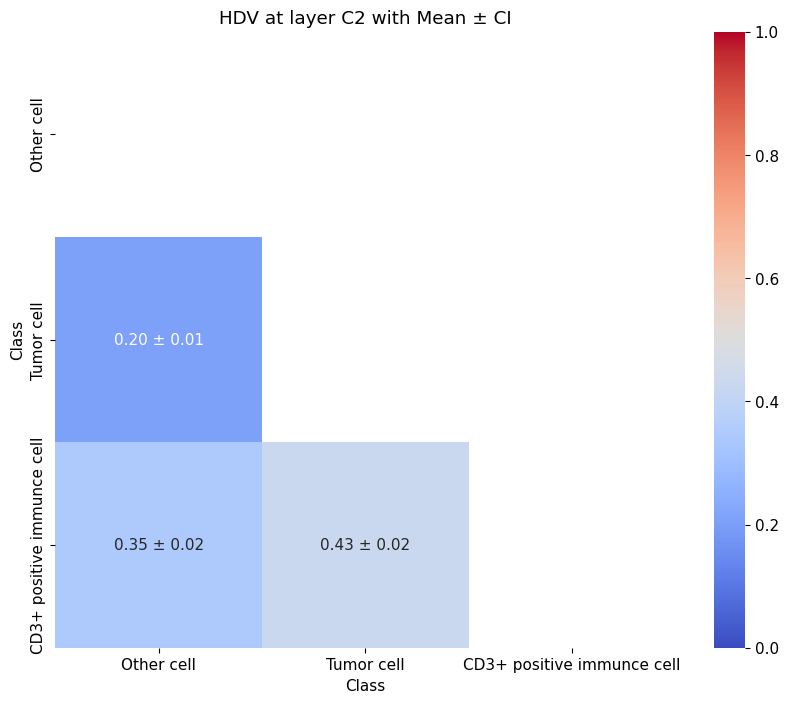

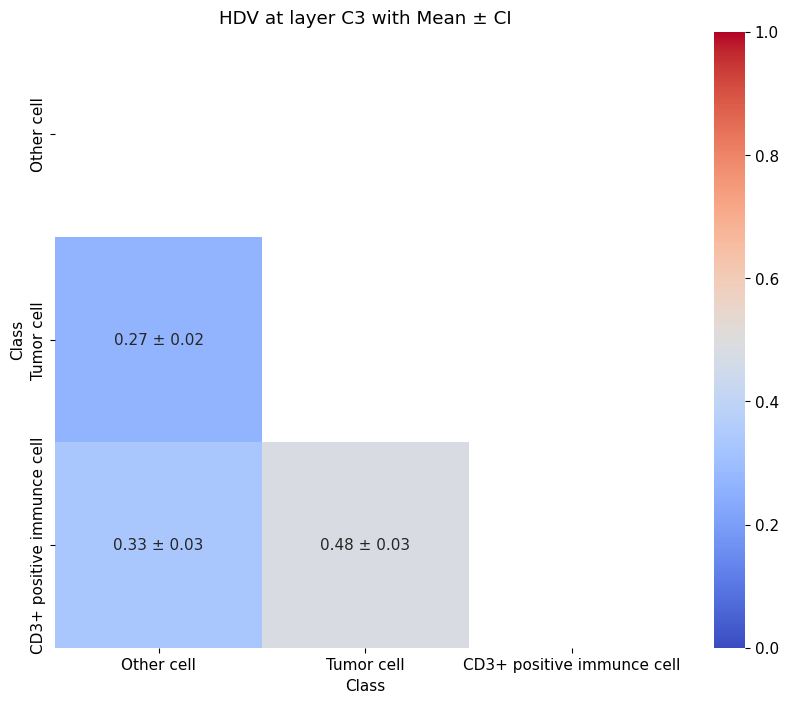

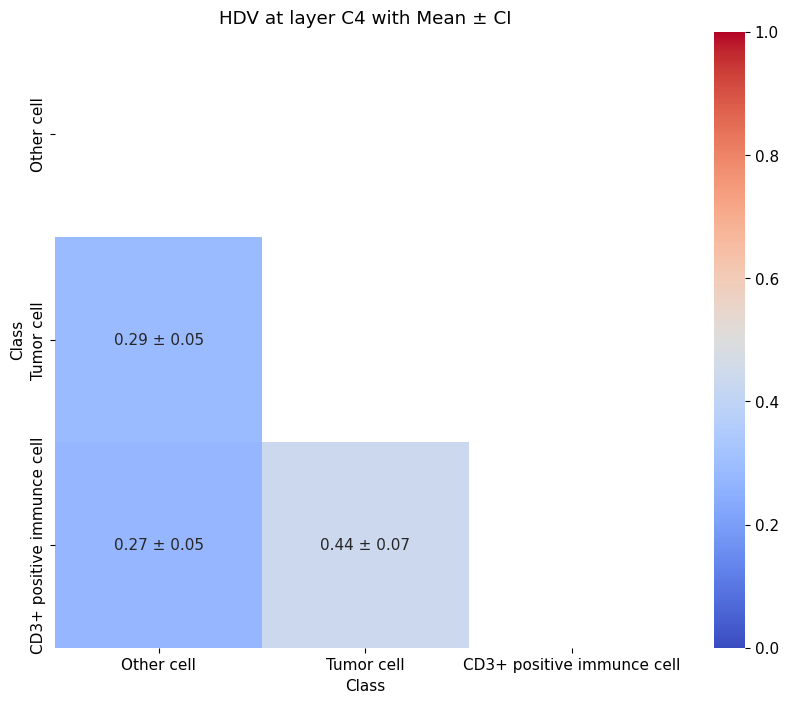

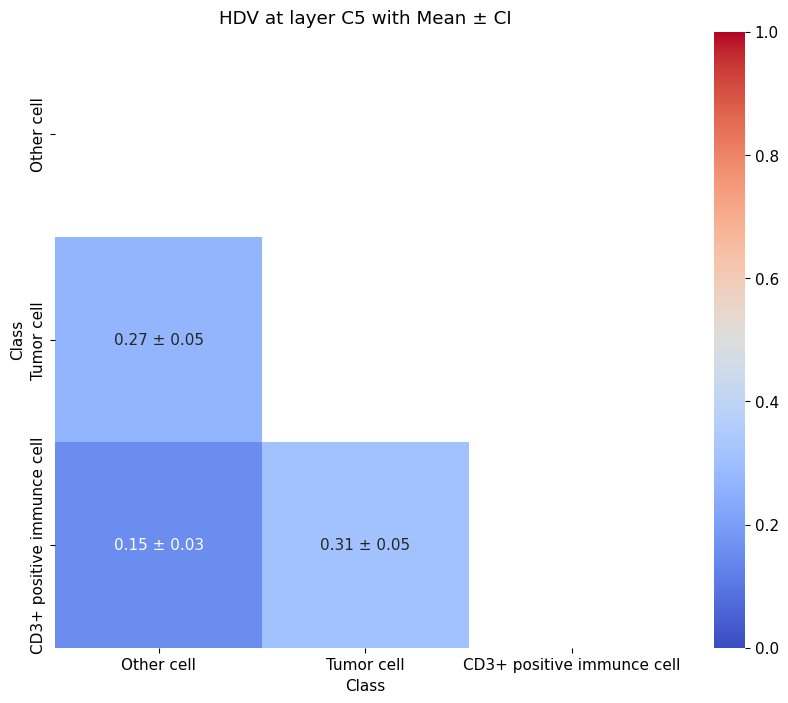

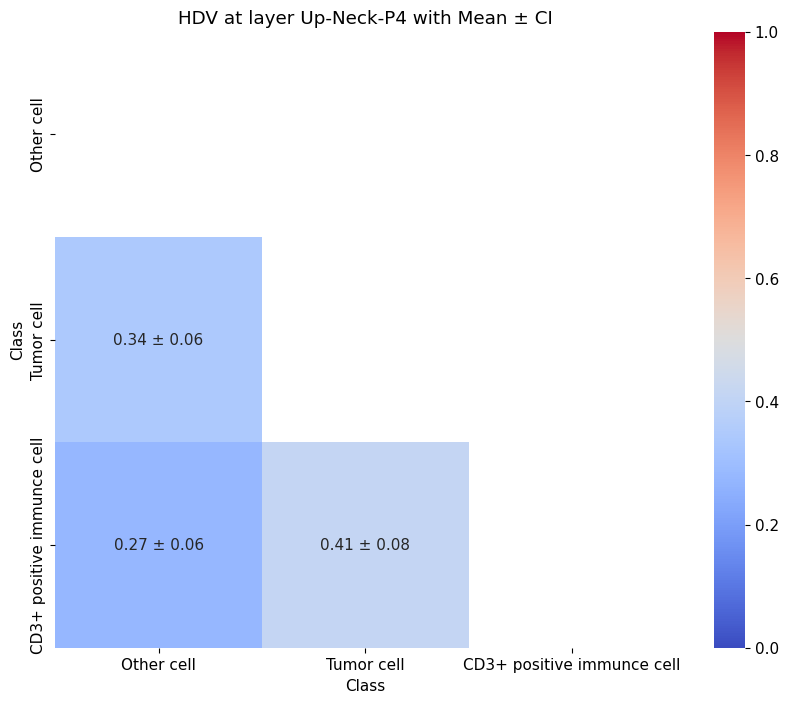

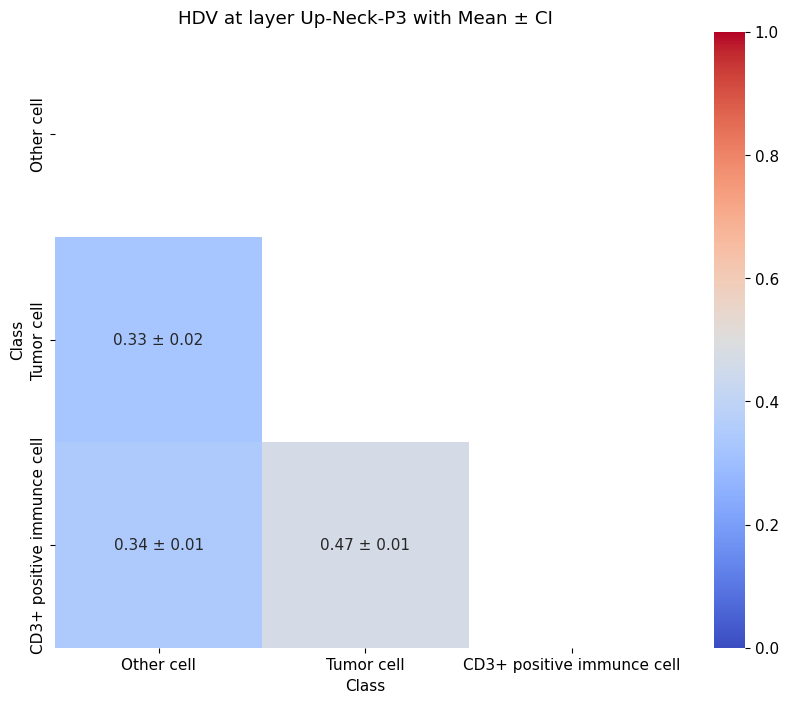

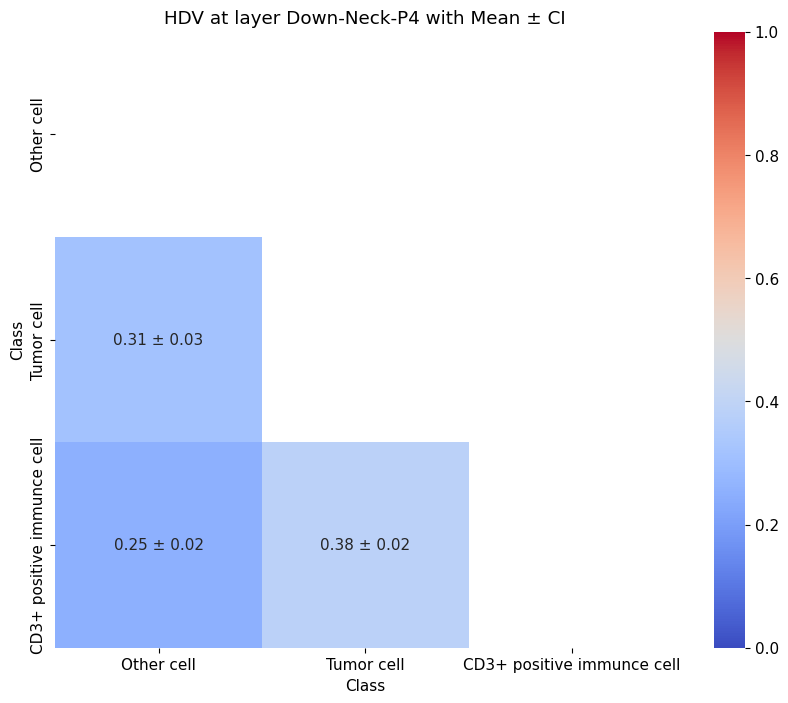

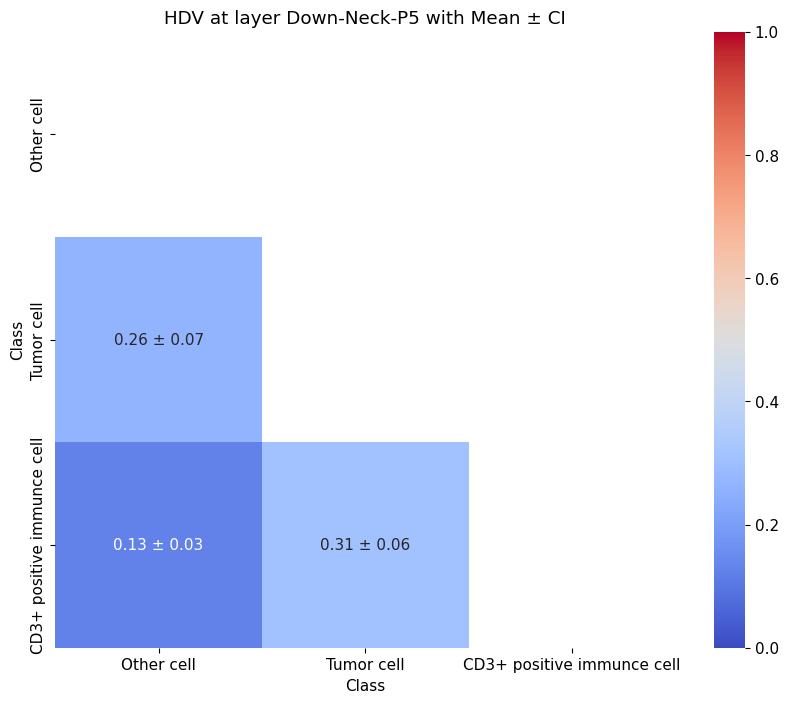

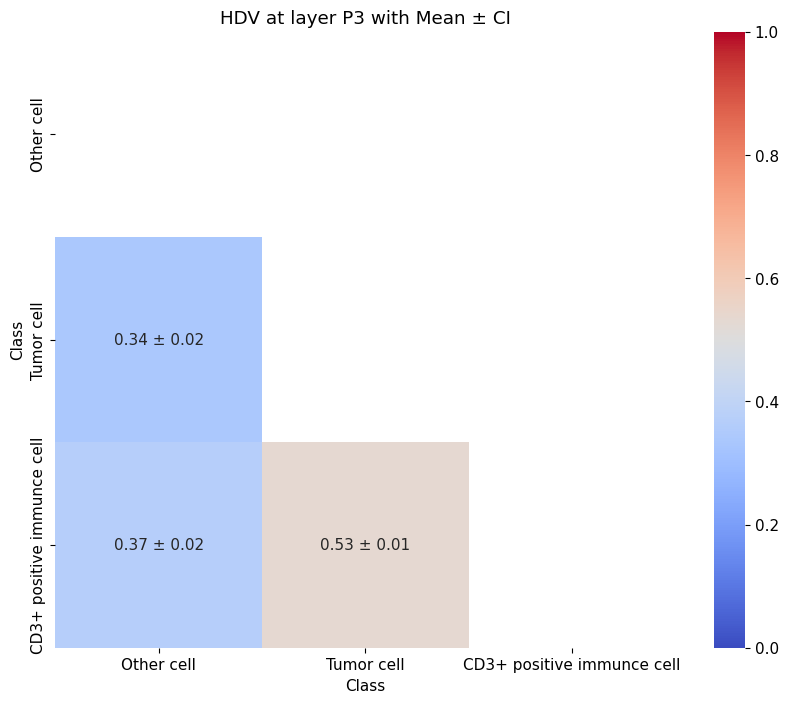

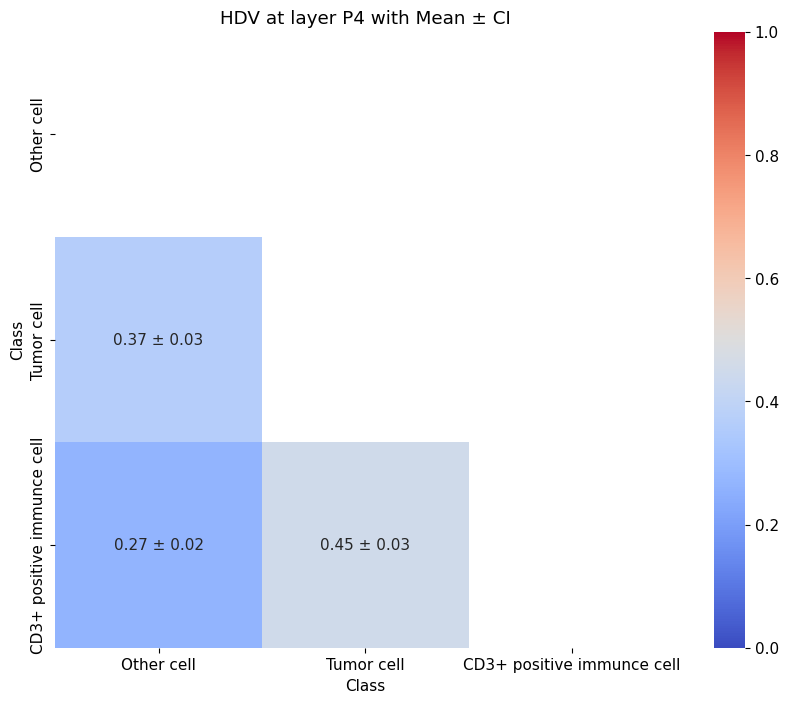

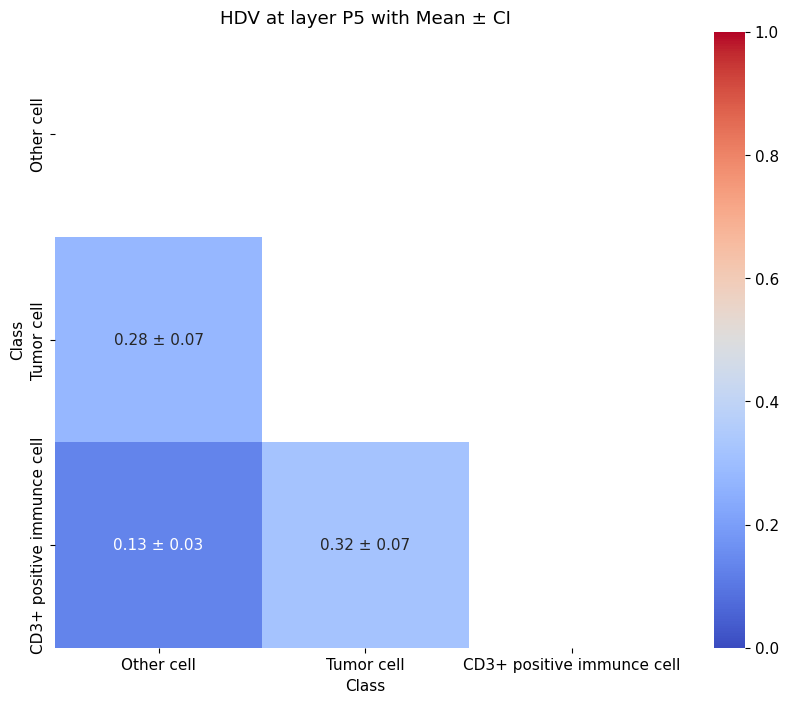

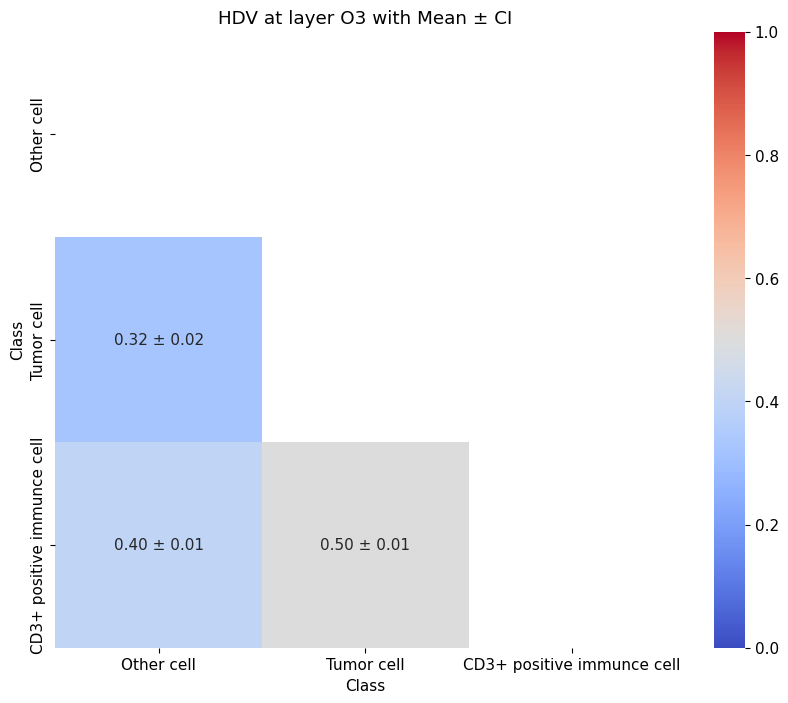

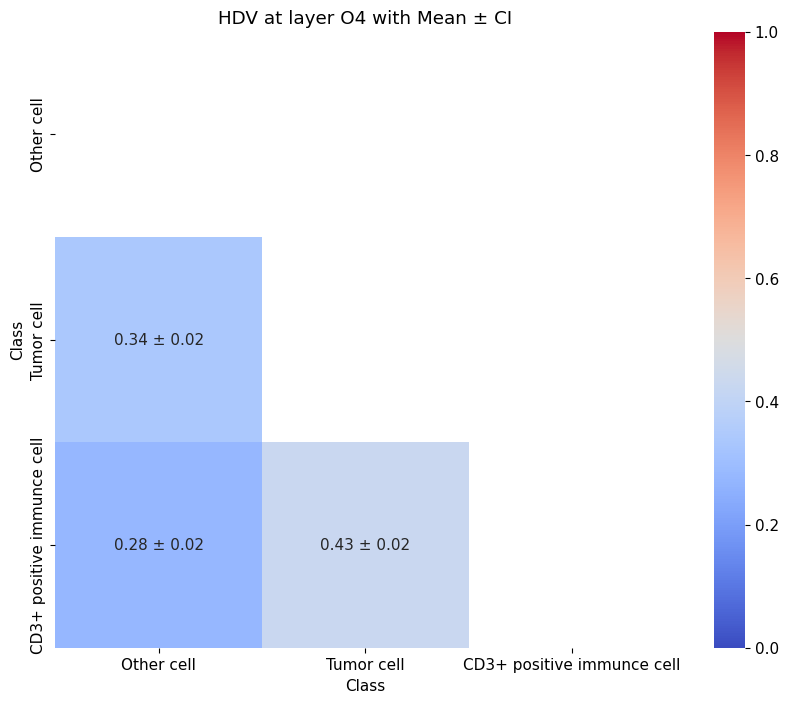

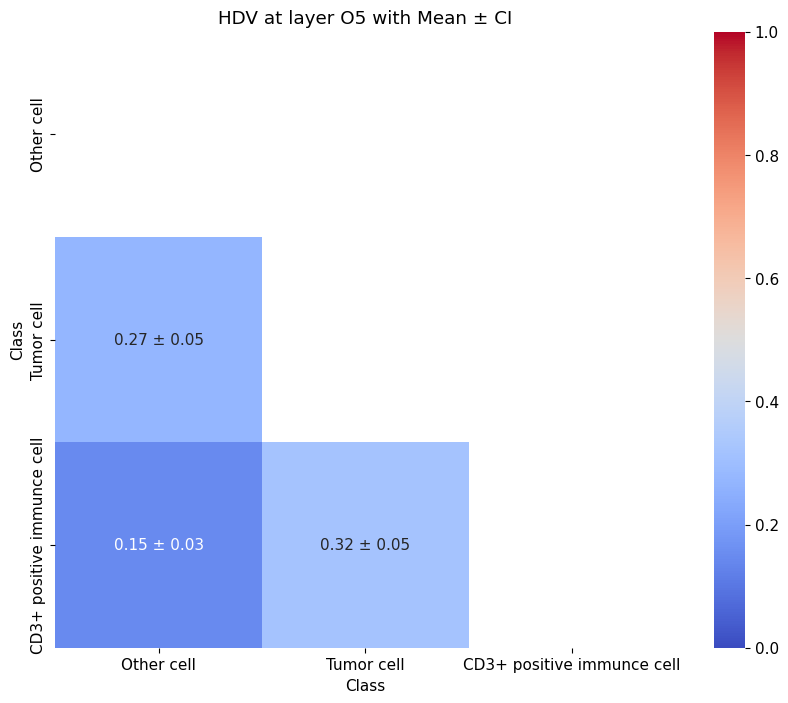

In [29]:
%matplotlib inline

model_name = 'yolov7_HNSCC_0'
result_dir = 'results/lymph'
class_names = lookups['class_id_to_label']
detector = 'yolov7'

layer_codes = constants.YOLO_LAYER_CODES

for layer in layer_codes:
    plot_multiclass_similarity(
        model_name, layer, result_dir, class_names, detector
    )